In [34]:
# import packages

import pandas as pd
import numpy as np
import os
import statsmodels.api as sm
import matplotlib.pyplot as plt
from kmodes.kmodes import KModes
from sklearn.linear_model import LinearRegression

# setting path

path = 'C:\Python\webscrape'
os.chdir(path) 

In [2]:
# reading from csv

data = pd.read_csv('steam_sales May, 12, 2019.txt', delimiter = '*', error_bad_lines = False)

b'Skipping line 2046: expected 6 fields, saw 7\nSkipping line 4379: expected 6 fields, saw 7\nSkipping line 4628: expected 6 fields, saw 7\nSkipping line 6310: expected 6 fields, saw 7\nSkipping line 8265: expected 6 fields, saw 7\nSkipping line 8802: expected 6 fields, saw 7\nSkipping line 9020: expected 6 fields, saw 7\nSkipping line 9259: expected 6 fields, saw 7\nSkipping line 11112: expected 6 fields, saw 7\nSkipping line 11113: expected 6 fields, saw 7\nSkipping line 11114: expected 6 fields, saw 7\nSkipping line 11115: expected 6 fields, saw 7\nSkipping line 11116: expected 6 fields, saw 7\nSkipping line 11117: expected 6 fields, saw 7\nSkipping line 11118: expected 6 fields, saw 7\nSkipping line 11119: expected 6 fields, saw 7\nSkipping line 11120: expected 6 fields, saw 7\nSkipping line 11121: expected 6 fields, saw 7\nSkipping line 11122: expected 6 fields, saw 7\nSkipping line 11123: expected 6 fields, saw 7\nSkipping line 11124: expected 6 fields, saw 7\nSkipping line 11125

In [3]:
# converting discount to decimal and replacing NA's with 0

data['discount'] = data['discount'].str.rstrip('%').astype('float') / 100.0 *(-1)
data[['discount','discounted price']] = data[['discount','discounted price']].fillna(value = 0)

In [4]:
# converting 'free to play' to 0 and stripping unecessary strings from original price

data = data.replace(to_replace = ['Free to Play', 'Free To Play', 'Free', 'Play for Free!', 
                                  'Free Demo', 'Free Movie', '1 Season', 'Third-party',
                                  'Play Now', 'Free Mod', 'From CDN$ 25.60', 'Install',
                                  'CDN$ 1,200.76', 'From CDN$ 25.31', 'From CDN$ 19.20'], value = np.nan)

data['original price'] = data['original price'].str.lstrip('CDN$ ').astype('float')
data['original price'] = data['original price'].fillna(value = 0)

In [5]:
# formatting discounted price

data = data.replace(to_replace = 'CDN$ 1,063.85							', value = np.nan)
data['discounted price'] = data['discounted price'].str.lstrip('CDN$ ').str.rstrip('\t\t\t\t\t\t\t').astype('float')
data['discounted price'] = data['discounted price'].fillna(value = data['original price'])

In [6]:
data.head()

,title,date,reviews,discount,original price,discounted price
0,Dota 2,9 Jul 2013,Very Positive,0.00,0.00,0.00
1,MORDHAU,29 Apr 2019,Mostly Positive,0.00,33.99,33.99
2,Stellaris,9 May 2016,Mostly Positive,0.75,43.99,10.99
3,Stellaris: Starter Pack,NaN,Mostly Positive,0.66,88.77,30.03
4,Counter-Strike: Global Offensive,21 Aug 2012,Very Positive,0.00,0.00,0.00


In [7]:
# filling in 'None' reviews and one hot encoding to handle categorical review variable

data['reviews'] = data['reviews'].fillna(value = 'None')
data = pd.concat([data ,pd.get_dummies(data['reviews'], drop_first = True)],axis=1)
data.drop(['reviews'], axis=1, inplace=True)

In [8]:
data.head()

,title,date,discount,original price,discounted price,Mostly Negative,Mostly Positive,None,Overwhelmingly Positive,Positive,Very Positive
0,Dota 2,9 Jul 2013,0.00,0.00,0.00,0,0,0,0,0,1
1,MORDHAU,29 Apr 2019,0.00,33.99,33.99,0,1,0,0,0,0
2,Stellaris,9 May 2016,0.75,43.99,10.99,0,1,0,0,0,0
3,Stellaris: Starter Pack,NaN,0.66,88.77,30.03,0,1,0,0,0,0
4,Counter-Strike: Global Offensive,21 Aug 2012,0.00,0.00,0.00,0,0,0,0,0,1


In [9]:
# exploratory analysis

data.describe()

,discount,original price,discounted price,Mostly Negative,Mostly Positive,None,Overwhelmingly Positive,Positive,Very Positive
count,26297.000000,26297.000000,26297.000000,26297.000000,26297.000000,26297.000000,26297.000000,26297.000000,26297.000000
mean,0.027135,11.869514,11.300751,0.000228,0.114462,0.391642,0.016428,0.202266,0.255733
std,0.124654,21.446670,19.595859,0.015104,0.318377,0.488127,0.127116,0.401697,0.436280
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.290000,2.290000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,5.690000,5.690000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,13.490000,12.990000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
max,1.000000,722.790000,722.790000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
# splitting original price and reviews

data_categorical = data[['original price', 'Mostly Negative', 'Mostly Positive', 'None', 'Overwhelmingly Positive',
              'Positive', 'Very Positive']]

In [23]:
# clustering on training data

km = KModes(n_clusters=4, init='Huang', n_init=5, verbose=1)

clusters = km.fit_predict(data_categorical)
kmodes = km.cluster_centroids_

# print the cluster centroids

print(kmodes)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 15, cost: 23816.0
Run 1, iteration: 2/100, moves: 0, cost: 23816.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 15183, cost: 23420.0
Run 2, iteration: 2/100, moves: 365, cost: 23420.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 2150, cost: 23925.0
Run 3, iteration: 2/100, moves: 25, cost: 23925.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 1862, cost: 23174.0
Run 4, iteration: 2/100, moves: 62, cost: 23174.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 1977, cost: 24570.0
Run 5, iteration: 2/100, moves: 33, cost: 24570.0
Best run was number 4
[[ 0.    0.    1.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    1. 

In [24]:
# 7 clusters = 22904
# 6 clusters = 23340
# 5 clusters = 23998
# 4 clusters = 24674
# 3 clusters = 30694
# seems the optimal number of clusters is 4

In [26]:
# For each cluster mode (a vector of "1" and "0")
# find and print the column headings where "1" appears.

shape = kmodes.shape

for i in range(shape[0]):
    if sum(kmodes[i,:]) == 0:
        print("\ncluster " + str(i) + ": ")
    else:
        print("\ncluster " + str(i) + ": ")
        cent = kmodes[i,:]
        for j in data.columns[np.nonzero(cent)]:
            print(j)


cluster 0: 
Mostly Positive

cluster 1: 
None

cluster 2: 
original price
Overwhelmingly Positive

cluster 3: 
original price
Very Positive

cluster 4: 
Very Positive

cluster 5: 
Positive


In [ ]:
# In retrospect, kmodes and clustering in general probably wasn't the greatest, as all categories are mutually exclusive
# Perhaps a linear regression would be a better way to model this ..

Text(0, 0.5, 'Original Price')

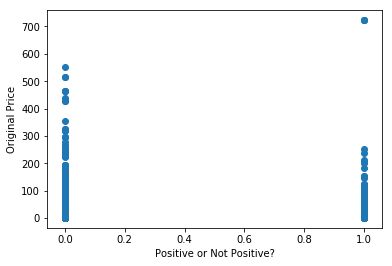

In [37]:
# visualization

plt.scatter(data['Positive'], data['original price'])
plt.xlabel("Positive or Not Positive?")
plt.ylabel("Original Price")

Text(0, 0.5, 'Original Price')

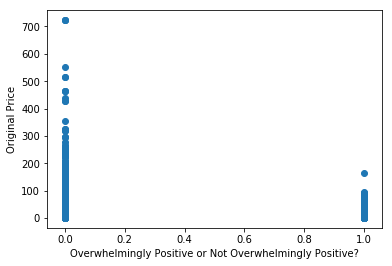

In [38]:
plt.scatter(data['Overwhelmingly Positive'], data['original price'])
plt.xlabel("Overwhelmingly Positive or Not Overwhelmingly Positive?")
plt.ylabel("Original Price")

Text(0, 0.5, 'Original Price')

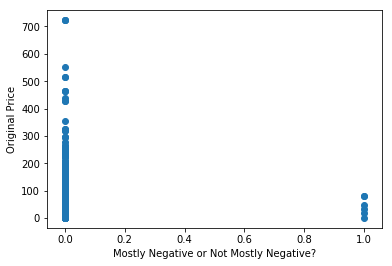

In [39]:
plt.scatter(data['Mostly Negative'], data['original price'])
plt.xlabel("Mostly Negative or Not Mostly Negative?")
plt.ylabel("Original Price")

Text(0, 0.5, 'Original Price')

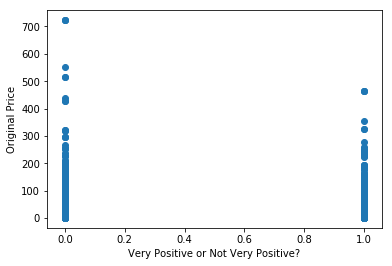

In [40]:
plt.scatter(data['Very Positive'], data['original price'])
plt.xlabel("Very Positive or Not Very Positive?")
plt.ylabel("Original Price")

Text(0, 0.5, 'Original Price')

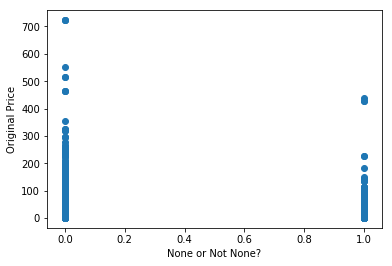

In [41]:
plt.scatter(data['None'], data['original price'])
plt.xlabel("None or Not None?")
plt.ylabel("Original Price")

Text(0, 0.5, 'Original Price')

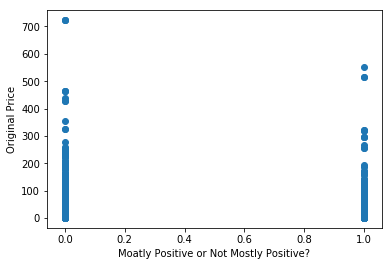

In [42]:
plt.scatter(data['Mostly Positive'], data['original price'])
plt.xlabel("Moatly Positive or Not Mostly Positive?")
plt.ylabel("Original Price")

In [35]:
# setting up x and y variables
x = data[['Mostly Negative', 'Mostly Positive', 'None', 'Overwhelmingly Positive',
              'Positive', 'Very Positive']]
y = data['original price']
model = LinearRegression().fit(x,y)

# printing intercept and coefficients 
print(model.intercept_)
print(model.coef_)

# printing statsmodel
x = sm.add_constant(x) # adding a constant
 
model = sm.OLS(y, x).fit()
predictions = model.predict(x) 
 
print_model = model.summary()
print(print_model)

18.989664031622283
[ 23.75200264  -3.24405938 -11.1778289   -0.5457057   -9.67257999
  -1.60770715]
                            OLS Regression Results                            
Dep. Variable:         original price   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     190.5
Date:                Sun, 02 Jun 2019   Prob (F-statistic):          1.87e-238
Time:                        17:09:44   Log-Likelihood:            -1.1737e+05
No. Observations:               26297   AIC:                         2.348e+05
Df Residuals:                   26290   BIC:                         2.348e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
------------------

c:\users\sliu742\appdata\local\programs\python\python37-32\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
